In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from entsoe import EntsoePandasClient

In [2]:
my_api_key = os.environ.get('ENTSOE_API_KEY')
client = EntsoePandasClient(api_key=my_api_key)

# Parameters of the dataset

In [3]:
country_code = 'HU'
years = [('2017-01-01', '2017-12-31'),
         ('2018-01-01', '2018-12-31'),
         ('2019-01-01', '2019-12-31'),
         ('2020-01-01', '2020-12-31'),
         ('2021-01-01', '2021-12-31'),
         ('2022-01-01', '2022-12-31'),
         ('2023-01-01', '2023-12-31'),
         ('2024-01-01', '2024-03-24')]

In [4]:
prices_folder_path = './data/prices'
loads_folder_path = './data/loads'
wind_solar_forecast_folder_path = './data/wind_solar_forecast'
weather_folder_path = './data/weather'

In [5]:
def get_base_df_filename(country_code, years):
    return f'./data/base_price_{country_code}_{years[0]}_{years[-1]}.csv'

def get_base_load_df_filename(country_code, years):
    return f'./data/base_load_avgs_{country_code}_{years[0]}_{years[-1]}.csv'

def get_base_wind_solar_forecast_df_filename(country_code, years):
    return f'./data/base_wind_solar_forecast_avgs_{country_code}_{years[0]}_{years[-1]}.csv'

In [6]:
def run_querry_day_ahead_prices(country_code, start_date, end_date):
    filename = f'price_{start_date}_{end_date}_{country_code}.csv'
    start_ts = pd.Timestamp(start_date, tz='Europe/Budapest')
    end_ts = pd.Timestamp(end_date, tz='Europe/Budapest')

    if os.path.exists(f'{prices_folder_path}/{filename}'):
        print(f'{prices_folder_path}/{filename} exists, reading from file')
        #load
        df = pd.read_csv(f'{prices_folder_path}/{filename}', index_col=0)
    else:
        print(f'{prices_folder_path}/{filename} does not exist, downloading from ENTSO-E')

        #set start time to 00:00:00 and end time to 23:59:59
        start_ts = pd.Timestamp(start_date, tz='Europe/Brussels')
        end_ts = pd.Timestamp(end_date, tz='Europe/Brussels') + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)

        df = client.query_day_ahead_prices(country_code, start=start_ts, end=end_ts)        # Data from ENTSO-E
        
        df.to_csv(f'{prices_folder_path}/{filename}')

    return df

In [7]:
def run_querry_load(country_code, start_date, end_date):
    filename = f'load_{start_date}_{end_date}_{country_code}.csv'
    start_ts = pd.Timestamp(start_date, tz='Europe/Budapest')
    end_ts = pd.Timestamp(end_date, tz='Europe/Budapest')

    if os.path.exists(f'{loads_folder_path}/{filename}'):
        print(f'{loads_folder_path}/{filename} exists, reading from file')
        #load
        df = pd.read_csv(f'{loads_folder_path}/{filename}', index_col=0)
    else:
        print(f'{loads_folder_path}/{filename} does not exist, downloading from ENTSO-E')

        #set start time to 00:00:00 and end time to 23:59:59
        start_ts = pd.Timestamp(start_date, tz='Europe/Brussels')
        end_ts = pd.Timestamp(end_date, tz='Europe/Brussels') + pd.Timedelta(days=1)

        df =client.query_load(country_code, start=start_ts, end=end_ts)        # Data from ENTSO-E
        
        df.to_csv(f'{loads_folder_path}/{filename}')

    return df

In [8]:
def run_querry_wind_solar_forecast(country_code, start_date, end_date):
    filename = f'wind_solar_forecast_{start_date}_{end_date}_{country_code}.csv'
    start_ts = pd.Timestamp(start_date, tz='Europe/Budapest')
    end_ts = pd.Timestamp(end_date, tz='Europe/Budapest')

    if os.path.exists(f'{wind_solar_forecast_folder_path}/{filename}'):
        print(f'{wind_solar_forecast_folder_path}/{filename} exists, reading from file')
        #load
        df = pd.read_csv(f'{wind_solar_forecast_folder_path}/{filename}', index_col=0)
    else:
        print(f'{wind_solar_forecast_folder_path}/{filename} does not exist, downloading from ENTSO-E')

        #set start time to 00:00:00 and end time to 23:59:59
        start_ts = pd.Timestamp(start_date, tz='Europe/Brussels')
        end_ts = pd.Timestamp(end_date, tz='Europe/Brussels') + pd.Timedelta(days=1)

        df =client.query_wind_and_solar_forecast(country_code, start=start_ts, end=end_ts)        # Data from ENTSO-E
        
        df.to_csv(f'{wind_solar_forecast_folder_path}/{filename}')

    return df

# Create the base concatenated df

First we will create a base concatenated dataframe with all the data from the different files but only the prices

In [9]:
def get_base_prices(country_code, years=years):
    base_df_filename = get_base_df_filename(country_code, years)
    if os.path.exists(base_df_filename):
        print(f'{base_df_filename} exists, reading from file')
        df = pd.read_csv(base_df_filename, index_col=0, parse_dates=True)
    else:
        print(f'{base_df_filename} does not exist, concatenating from multiple files')

        for (start_date, end_date) in years:
            df_temp = run_querry_day_ahead_prices(country_code, start_date, end_date)

            df = df_temp if (start_date, end_date) == years[0] else pd.concat([df, df_temp])

        df.columns = [f'Price_{country_code}']
        df['Datetime'] = df.index
        df['Datetime'] = pd.to_datetime(df['Datetime'], utc=True)
        df.reset_index(drop=True, inplace=True)
        #order by datetime
        df = df.sort_values(by='Datetime')
        df = df.set_index('Datetime')
        #add 1 hour to the datetime
        df.index = df.index + pd.DateOffset(hours=1)
        df.to_csv(base_df_filename)
    return df

In [10]:
def load_15min_to_hourly(df, col_name, target_col_name):
    df['Date'] = df.index.floor('h')
    df[target_col_name] = df.groupby('Date')[col_name].transform('mean')
    df2 = df[['Date', target_col_name]]
    df2 = df2.drop_duplicates()
    return df

In [11]:
def get_base_load_avg(country_code, years=years):
    base_load_df_filename = get_base_load_df_filename(country_code, years)
    if os.path.exists(base_load_df_filename):
        print(f'{base_load_df_filename} exists, reading from file')
        df = pd.read_csv(base_load_df_filename, index_col=0, parse_dates=True)
    else:
        print(f'{base_load_df_filename} does not exist, concatenating from multiple files')

        for (start_date, end_date) in years:

            df_temp = run_querry_load(country_code, start_date, end_date)

            df = df_temp if (start_date, end_date) == years[0] else pd.concat([df, df_temp])
            
        df['Datetime'] = df.index
        df['Datetime'] = pd.to_datetime(df['Datetime'], utc=True)
        df.reset_index(drop=True, inplace=True)
        #order by datetime
        df = df.sort_values(by='Datetime')
        df = df.set_index('Datetime')
        #add 1 hour to the datetime
        df.index = df.index + pd.DateOffset(hours=1)
        df = load_15min_to_hourly(df, 'Actual Load', 'Load_avg')
        df = df[['Date', 'Load_avg']].drop_duplicates()
        df.drop(columns=['Date'], inplace=True)
        df.columns = [f'Load_avg_{country_code}']
        df.to_csv(base_load_df_filename)
    return df

In [12]:
def get_base_wind_solar_forecast_avg(country_code, years=years):
    base_wind_solar_forecast_df_filename = get_base_wind_solar_forecast_df_filename(country_code, years)
    if os.path.exists(base_wind_solar_forecast_df_filename):
        print(f'{base_wind_solar_forecast_df_filename} exists, reading from file')
        df = pd.read_csv(base_wind_solar_forecast_df_filename, index_col=0, parse_dates=True)
    else:
        print(f'{base_wind_solar_forecast_df_filename} does not exist, concatenating from multiple files')

        for (start_date, end_date) in years:

            df_temp = run_querry_wind_solar_forecast(country_code, start_date, end_date)

            df = df_temp if (start_date, end_date) == years[0] else pd.concat([df, df_temp])
            
        df['Datetime'] = df.index
        df['Datetime'] = pd.to_datetime(df['Datetime'], utc=True)
        df.reset_index(drop=True, inplace=True)
        #order by datetime
        df = df.sort_values(by='Datetime')
        df = df.set_index('Datetime')
        #add 1 hour to the datetime
        df.index = df.index + pd.DateOffset(hours=1)
        df = load_15min_to_hourly(df, 'Solar', 'Solar_Fcast_avg')
        df = load_15min_to_hourly(df, 'Wind Onshore', 'Wind_Onshore_avg')

        df = df[['Date', 'Solar_Fcast_avg', 'Wind_Onshore_avg']].drop_duplicates()
        df.drop(columns=['Date'], inplace=True)
        df.columns = [f'Solar_Fcast_avg_{country_code}', f'Wind_Onshore_avg_{country_code}']
        df.to_csv(base_wind_solar_forecast_df_filename)
    return df

In [13]:
def get_base_df(country_codes):
    for country_code in country_codes:
        print('Starting to collect data for', country_code)
        prices_df = get_base_prices(country_code)
        load_avg_df = get_base_load_avg(country_code)
        wind_solar_forecast_df = get_base_wind_solar_forecast_avg(country_code)
        
        df = pd.concat([prices_df, load_avg_df, wind_solar_forecast_df], axis=1)
        df = df.dropna()
        df = df.reset_index()
        df = df.rename(columns={'index': 'Datetime'})
        df_final = df if country_code == country_codes[0] else pd.merge(df_final, df, on='Datetime', how='inner')

    return df_final

In [14]:
country_codes = ['HU', 'RO']
df = get_base_df(country_codes)

Starting to collect data for HU
./data/base_price_HU_('2017-01-01', '2017-12-31')_('2024-01-01', '2024-03-24').csv exists, reading from file


./data/base_load_avgs_HU_('2017-01-01', '2017-12-31')_('2024-01-01', '2024-03-24').csv exists, reading from file
./data/base_wind_solar_forecast_avgs_HU_('2017-01-01', '2017-12-31')_('2024-01-01', '2024-03-24').csv exists, reading from file
Starting to collect data for RO
./data/base_price_RO_('2017-01-01', '2017-12-31')_('2024-01-01', '2024-03-24').csv exists, reading from file
./data/base_load_avgs_RO_('2017-01-01', '2017-12-31')_('2024-01-01', '2024-03-24').csv exists, reading from file
./data/base_wind_solar_forecast_avgs_RO_('2017-01-01', '2017-12-31')_('2024-01-01', '2024-03-24').csv exists, reading from file


In [15]:
df

,Datetime,Price_HU,Load_avg_HU,Solar_Fcast_avg_HU,Wind_Onshore_avg_HU,Price_RO,Load_avg_RO,Solar_Fcast_avg_RO,Wind_Onshore_avg_RO
0,2019-01-01 00:00:00+00:00,59.90,4082.00,0.0,19.75,279.00,6110.00,0.0,88.00
1,2019-01-01 01:00:00+00:00,52.71,3985.75,0.0,27.25,245.54,5856.00,0.0,95.00
2,2019-01-01 02:00:00+00:00,36.49,3732.50,0.0,19.75,169.98,5675.00,0.0,90.00
3,2019-01-01 03:00:00+00:00,31.24,3554.25,0.0,7.25,145.52,5570.00,0.0,86.00
4,2019-01-01 04:00:00+00:00,25.98,3499.25,0.0,1.75,121.00,5524.00,0.0,83.00
...,...,...,...,...,...,...,...,...,...
45654,2024-03-24 19:00:00+00:00,85.22,5588.50,0.0,63.25,85.46,6560.25,1.0,1105.25
45655,2024-03-24 20:00:00+00:00,76.51,5461.00,0.0,65.75,76.65,6317.25,1.0,1016.75
45656,2024-03-24 21:00:00+00:00,73.74,5193.50,0.0,68.00,73.68,5877.25,1.0,928.25
45657,2024-03-24 22:00:00+00:00,70.07,4897.25,0.0,71.75,70.10,5498.75,1.0,938.75


## Concatenate weather data

In [16]:
filename = "weather_BP_('2017-01-01', '2024-03-24').csv"
weather_df = pd.read_csv(f'{weather_folder_path}/{filename}', index_col=0, parse_dates=True)

In [17]:
weather_df['Datetime'] = pd.to_datetime(weather_df.index)
weather_df.reset_index(drop=True, inplace=True)

In [18]:
weather_df

,temperature_2m_BP,relative_humidity_2m_BP,pressure_msl_BP,surface_pressure_BP,precipitation_BP,rain_BP,cloud_cover_BP,cloud_cover_low_BP,cloud_cover_mid_BP,cloud_cover_high_BP,shortwave_radiation_BP,direct_radiation_BP,diffuse_radiation_BP,sunshine_duration_BP,wind_speed_10m_BP,wind_speed_100m_BP,wind_direction_10m_BP,wind_direction_100m_BP,wind_gusts_10m_BP,Datetime
0,-3.579,95.965530,1029.6,1014.72410,0.0,0.0,100.000000,96.0,0.0,94.0,0.0,0.0,0.0,0.0,6.379216,9.178235,286.38962,295.55990,12.599999,2017-01-01 00:00:00+00:00
1,-4.429,95.937294,1029.4,1014.48020,0.0,0.0,65.400000,44.0,0.0,86.0,0.0,0.0,0.0,0.0,5.091168,13.104198,315.00010,307.18478,10.080000,2017-01-01 01:00:00+00:00
2,-6.079,95.514830,1028.7,1013.69916,0.0,0.0,61.800000,41.0,0.0,83.0,0.0,0.0,0.0,0.0,7.200000,11.720751,323.13000,317.48960,10.799999,2017-01-01 02:00:00+00:00
3,-5.729,95.893540,1028.3,1013.32450,0.0,0.0,54.600000,32.0,0.0,86.0,0.0,0.0,0.0,0.0,5.860375,9.957108,317.48960,319.39877,10.799999,2017-01-01 03:00:00+00:00
4,-5.279,99.244804,1027.9,1012.95520,0.0,0.0,44.100000,47.0,0.0,6.0,0.0,0.0,0.0,0.0,2.741678,6.792466,336.80140,327.99466,9.000000,2017-01-01 04:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63355,5.421,80.713320,1007.2,993.11400,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.830519,18.079027,251.56496,257.34744,12.959999,2024-03-24 19:00:00+00:00
63356,4.171,88.378944,1007.1,992.95240,0.0,0.0,1.800000,2.0,0.0,0.0,0.0,0.0,0.0,0.0,6.830519,19.353140,251.56496,260.36252,12.240000,2024-03-24 20:00:00+00:00
63357,3.721,90.892494,1007.0,992.83105,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.072878,19.813087,255.25640,267.91748,12.959999,2024-03-24 21:00:00+00:00
63358,3.471,90.874850,1006.8,992.62103,0.0,0.0,11.400001,0.0,11.0,16.0,0.0,0.0,0.0,0.0,8.350138,22.505037,262.56870,277.35230,14.400000,2024-03-24 22:00:00+00:00


In [19]:
df = pd.merge(df, weather_df, on='Datetime', how='inner')

In [20]:
df

,Datetime,Price_HU,Load_avg_HU,Solar_Fcast_avg_HU,Wind_Onshore_avg_HU,Price_RO,Load_avg_RO,Solar_Fcast_avg_RO,Wind_Onshore_avg_RO,temperature_2m_BP,...,cloud_cover_high_BP,shortwave_radiation_BP,direct_radiation_BP,diffuse_radiation_BP,sunshine_duration_BP,wind_speed_10m_BP,wind_speed_100m_BP,wind_direction_10m_BP,wind_direction_100m_BP,wind_gusts_10m_BP
0,2019-01-01 00:00:00+00:00,59.90,4082.00,0.0,19.75,279.00,6110.00,0.0,88.00,-1.579,...,40.0,0.0,0.0,0.0,0.0,6.109403,10.895577,315.00010,352.40543,11.159999
1,2019-01-01 01:00:00+00:00,52.71,3985.75,0.0,27.25,245.54,5856.00,0.0,95.00,-1.579,...,3.0,0.0,0.0,0.0,0.0,5.991594,10.315115,302.73520,330.75128,11.879999
2,2019-01-01 02:00:00+00:00,36.49,3732.50,0.0,19.75,169.98,5675.00,0.0,90.00,-1.879,...,0.0,0.0,0.0,0.0,0.0,6.120000,10.195057,298.07240,317.86246,10.799999
3,2019-01-01 03:00:00+00:00,31.24,3554.25,0.0,7.25,145.52,5570.00,0.0,86.00,-1.779,...,0.0,0.0,0.0,0.0,0.0,8.217153,17.826363,298.81070,313.36346,15.119999
4,2019-01-01 04:00:00+00:00,25.98,3499.25,0.0,1.75,121.00,5524.00,0.0,83.00,-2.279,...,96.0,0.0,0.0,0.0,0.0,6.439876,15.546833,296.56497,312.18436,15.119999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45654,2024-03-24 19:00:00+00:00,85.22,5588.50,0.0,63.25,85.46,6560.25,1.0,1105.25,5.421,...,0.0,0.0,0.0,0.0,0.0,6.830519,18.079027,251.56496,257.34744,12.959999
45655,2024-03-24 20:00:00+00:00,76.51,5461.00,0.0,65.75,76.65,6317.25,1.0,1016.75,4.171,...,0.0,0.0,0.0,0.0,0.0,6.830519,19.353140,251.56496,260.36252,12.240000
45656,2024-03-24 21:00:00+00:00,73.74,5193.50,0.0,68.00,73.68,5877.25,1.0,928.25,3.721,...,0.0,0.0,0.0,0.0,0.0,7.072878,19.813087,255.25640,267.91748,12.959999
45657,2024-03-24 22:00:00+00:00,70.07,4897.25,0.0,71.75,70.10,5498.75,1.0,938.75,3.471,...,16.0,0.0,0.0,0.0,0.0,8.350138,22.505037,262.56870,277.35230,14.400000


# Create more input features

In [21]:
target_country_code = 'HU'

In [22]:
df['month'] = df['Datetime'].dt.month
df['day'] = df['Datetime'].dt.day
df['hour'] = df['Datetime'].dt.hour
df['weekday'] = df['Datetime'].dt.weekday
df['dayoftheweek'] = df['Datetime'].dt.dayofweek
df['date'] = df['Datetime'].dt.date

In [23]:
month_dummies = pd.get_dummies(df['month'], prefix='month', drop_first=True)
dayofweek_dummies = pd.get_dummies(df['dayoftheweek'], prefix='dayofweek', drop_first=True)
df = pd.concat([df, month_dummies, dayofweek_dummies], axis=1)

In [24]:
dummy_columns = month_dummies.columns.tolist() + dayofweek_dummies.columns.tolist()

In [25]:
df['Datetime-2d'] = df['Datetime'] + pd.to_timedelta(-2, unit='day')
df['Datetime-7d'] = df['Datetime'] + pd.to_timedelta(-7, unit='day')

load_map = df.set_index('Datetime')[f'Price_{target_country_code}']

df['Price-2d'] = df['Datetime-2d'].map(load_map)
df['Price-7d'] = df['Datetime-7d'].map(load_map)

In [26]:
df.isnull().sum()

Datetime                     0
Price_HU                     0
Load_avg_HU                  0
Solar_Fcast_avg_HU           0
Wind_Onshore_avg_HU          0
Price_RO                     0
Load_avg_RO                  0
Solar_Fcast_avg_RO           0
Wind_Onshore_avg_RO          0
temperature_2m_BP            0
relative_humidity_2m_BP      0
pressure_msl_BP              0
surface_pressure_BP          0
precipitation_BP             0
rain_BP                      0
cloud_cover_BP               0
cloud_cover_low_BP           0
cloud_cover_mid_BP           0
cloud_cover_high_BP          0
shortwave_radiation_BP       0
direct_radiation_BP          0
diffuse_radiation_BP         0
sunshine_duration_BP         0
wind_speed_10m_BP            0
wind_speed_100m_BP           0
wind_direction_10m_BP        0
wind_direction_100m_BP       0
wind_gusts_10m_BP            0
month                        0
day                          0
hour                         0
weekday                      0
dayofthe

In [27]:
df = df.dropna().reset_index(drop=True)

In [28]:
df

,Datetime,Price_HU,Load_avg_HU,Solar_Fcast_avg_HU,Wind_Onshore_avg_HU,Price_RO,Load_avg_RO,Solar_Fcast_avg_RO,Wind_Onshore_avg_RO,temperature_2m_BP,...,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,Datetime-2d,Datetime-7d,Price-2d,Price-7d
0,2019-01-08 00:00:00+00:00,51.40,5069.50,0.0,22.50,181.78,6959.00,0.0,1456.00,-8.129001,...,True,False,False,False,False,False,2019-01-06 00:00:00+00:00,2019-01-01 00:00:00+00:00,50.81,59.90
1,2019-01-08 01:00:00+00:00,42.99,4876.25,0.0,31.75,170.46,6874.00,0.0,1397.00,-7.129000,...,True,False,False,False,False,False,2019-01-06 01:00:00+00:00,2019-01-01 01:00:00+00:00,47.95,52.71
2,2019-01-08 02:00:00+00:00,41.00,4672.50,0.0,32.00,161.23,6860.00,0.0,1347.00,-5.929000,...,True,False,False,False,False,False,2019-01-06 02:00:00+00:00,2019-01-01 02:00:00+00:00,46.07,36.49
3,2019-01-08 03:00:00+00:00,39.76,4583.00,0.0,36.50,185.47,6923.00,0.0,1221.00,-5.579000,...,True,False,False,False,False,False,2019-01-06 03:00:00+00:00,2019-01-01 03:00:00+00:00,42.86,31.24
4,2019-01-08 04:00:00+00:00,42.77,4685.75,0.0,49.75,199.50,7133.00,0.0,1048.00,-5.429000,...,True,False,False,False,False,False,2019-01-06 04:00:00+00:00,2019-01-01 04:00:00+00:00,43.01,25.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45141,2024-03-24 19:00:00+00:00,85.22,5588.50,0.0,63.25,85.46,6560.25,1.0,1105.25,5.421000,...,False,False,False,False,False,True,2024-03-22 19:00:00+00:00,2024-03-17 19:00:00+00:00,114.84,87.46
45142,2024-03-24 20:00:00+00:00,76.51,5461.00,0.0,65.75,76.65,6317.25,1.0,1016.75,4.171000,...,False,False,False,False,False,True,2024-03-22 20:00:00+00:00,2024-03-17 20:00:00+00:00,90.77,77.89
45143,2024-03-24 21:00:00+00:00,73.74,5193.50,0.0,68.00,73.68,5877.25,1.0,928.25,3.721000,...,False,False,False,False,False,True,2024-03-22 21:00:00+00:00,2024-03-17 21:00:00+00:00,78.11,72.33
45144,2024-03-24 22:00:00+00:00,70.07,4897.25,0.0,71.75,70.10,5498.75,1.0,938.75,3.471000,...,False,False,False,False,False,True,2024-03-22 22:00:00+00:00,2024-03-17 22:00:00+00:00,75.69,72.10


In [29]:
from workalendar.europe import Hungary

cal = Hungary()
year_list = df['Datetime'].dt.year.unique()

In [30]:
holiday_df = pd.DataFrame()
for year in year_list:
    holidays = cal.holidays(year)
    temp_df = pd.DataFrame(holidays, columns=['date', 'holiday_name'])
    holiday_df = pd.concat([holiday_df, temp_df],
                           axis=0).reset_index(drop=True)

In [31]:
holiday_map = holiday_df.set_index('date')['holiday_name']
df['holiday_name'] = df['date'].map(holiday_map)
df['is_holiday'] = 0
df.loc[df['holiday_name'].notnull(), 'is_holiday'] = 1

df.drop(columns=['holiday_name'], inplace=True)

# Evaluation metric

In [32]:
def base_eval(y_true, y_pred):
    error = np.mean(abs(y_true - y_pred))
    print(f'Base evaluation (abs error): {error}')

In [33]:
def weighted_eval(y_true, y_pred, load):
    error = np.mean(abs((y_true - y_pred)*load))
    print(f'Weighted evaluation (abs error): {error}')

In [34]:
def do_modeling(model, train_df, test_df, input_cols, target_col):
    model.fit(train_df[input_cols], train_df[target_col])
    y_pred = model.predict(test_df[input_cols])
    y_true = test_df[target_col]
    base_eval(y_true, y_pred)
    weighted_eval(y_true, y_pred, test_df['Load_avg'])

# Testing on models

In [35]:
df.head(1).T

,0
Datetime,2019-01-08 00:00:00+00:00
Price_HU,51.4
Load_avg_HU,5069.5
Solar_Fcast_avg_HU,0.0
Wind_Onshore_avg_HU,22.5
Price_RO,181.78
Load_avg_RO,6959.0
Solar_Fcast_avg_RO,0.0
Wind_Onshore_avg_RO,1456.0
temperature_2m_BP,-8.129001


In [36]:
test_end_date = '2024-03-17'

In [37]:
do_not_use_cols = ['Price_HU', 'Datetime', 'month', 'day', 'hour', 'weekday', 'dayoftheweek', 'date', 'Datetime-2d', 'Datetime-7d']

In [38]:
in_cols = set(df.columns.tolist()) - set(do_not_use_cols)
target_col = f'Price_{target_country_code}'

In [39]:
in_cols = list(in_cols)
in_cols

['month_5',
 'cloud_cover_low_BP',
 'surface_pressure_BP',
 'wind_gusts_10m_BP',
 'cloud_cover_BP',
 'Solar_Fcast_avg_RO',
 'cloud_cover_mid_BP',
 'month_10',
 'wind_direction_10m_BP',
 'dayofweek_1',
 'wind_speed_100m_BP',
 'Solar_Fcast_avg_HU',
 'pressure_msl_BP',
 'dayofweek_6',
 'Load_avg_HU',
 'month_12',
 'dayofweek_4',
 'wind_speed_10m_BP',
 'Price_RO',
 'wind_direction_100m_BP',
 'month_9',
 'Price-7d',
 'sunshine_duration_BP',
 'month_7',
 'month_11',
 'Load_avg_RO',
 'month_3',
 'month_8',
 'precipitation_BP',
 'temperature_2m_BP',
 'relative_humidity_2m_BP',
 'dayofweek_3',
 'direct_radiation_BP',
 'cloud_cover_high_BP',
 'Price-2d',
 'shortwave_radiation_BP',
 'month_6',
 'month_4',
 'rain_BP',
 'is_holiday',
 'month_2',
 'dayofweek_5',
 'Wind_Onshore_avg_HU',
 'Wind_Onshore_avg_RO',
 'diffuse_radiation_BP',
 'dayofweek_2']

## Baseline

In [40]:
def baseline_model(df):
    y_pred = df[f'Price_{target_country_code}'].shift(7*24)
    return y_pred

In [41]:
base_pred = baseline_model(df)
start_date = '2023-01-01'
end_date = '2024-03-17'
base_eval(df.loc[df['Datetime'] >= test_end_date, target_col], base_pred)
weighted_eval(df.loc[df['Datetime'] >= test_end_date, target_col], base_pred, df.loc[df['Datetime'] >= test_end_date, f'Load_avg_{target_country_code}'])

Base evaluation (abs error): 16.567239583333333
Weighted evaluation (abs error): 77618.14497395833


## ARIMA

As another base model

In [42]:
from statsmodels.tsa.arima.model import ARIMA

In [43]:
df_train = df.loc[df['Datetime'] < test_end_date]

In [44]:
#create an ARIMA model, train it on 2017-2022 and forecast 2023
model = ARIMA(df_train.loc[:,f'Price_{target_country_code}'], order=(12,1,1))
model = model.fit()

In [45]:
arima_pred = model.forecast(steps=len(df.loc[df['Datetime'] >= test_end_date]))

In [46]:
# evaluate the model
base_eval(df.loc[df['Datetime'] >= test_end_date, target_col], arima_pred)
weighted_eval(df.loc[df['Datetime'] >= test_end_date, target_col], arima_pred, df.loc[df['Datetime'] >= test_end_date, f'Load_avg_{target_country_code}'])

Base evaluation (abs error): 21.93563974563405
Weighted evaluation (abs error): 107019.05274380276


## Gradient Boosting Regressor

In [47]:
from sklearn.ensemble import GradientBoostingRegressor

In [48]:
gbr = GradientBoostingRegressor(random_state=42)

In [49]:
train = df.loc[df['Datetime'] <= test_end_date]
test = df.loc[df['Datetime'] > test_end_date]

X_train = train[in_cols]
y_train = train[target_col]
X_test = test[in_cols]
y_test = test[target_col]

In [50]:
gbr.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [51]:
gbr_pred = gbr.predict(X_test)

In [52]:
base_eval(y_test, gbr_pred)
weighted_eval(y_test, gbr_pred, test[f'Load_avg_{target_country_code}'])

Base evaluation (abs error): 10.959867917091392
Weighted evaluation (abs error): 51516.66492555058


In [53]:
# zip the feature importances with the column names and sort them from the most to the least important
feature_importances = list(zip(X_train.columns, gbr.feature_importances_))
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
feature_importances

[('Price-7d', 0.44053342033334925),
 ('Price_RO', 0.2814150406789753),
 ('Price-2d', 0.2707232350424686),
 ('temperature_2m_BP', 0.0012962826051169257),
 ('Load_avg_HU', 0.0012444022913972676),
 ('dayofweek_1', 0.0006516857564756012),
 ('Wind_Onshore_avg_RO', 0.0005702257541025571),
 ('dayofweek_6', 0.0005588654047805875),
 ('is_holiday', 0.00040853792613598344),
 ('Solar_Fcast_avg_HU', 0.00037765522613363223),
 ('wind_direction_100m_BP', 0.00031750124280619283),
 ('dayofweek_5', 0.0002968576733270398),
 ('month_12', 0.00028550664779812595),
 ('surface_pressure_BP', 0.00026934408856010253),
 ('Wind_Onshore_avg_HU', 0.00025338582304096287),
 ('month_10', 0.00023101512029351614),
 ('Load_avg_RO', 9.823224566748033e-05),
 ('direct_radiation_BP', 6.869148390499795e-05),
 ('wind_speed_10m_BP', 6.113803419895526e-05),
 ('Solar_Fcast_avg_RO', 5.146029251146204e-05),
 ('pressure_msl_BP', 4.616805774916176e-05),
 ('cloud_cover_mid_BP', 4.44223185808446e-05),
 ('cloud_cover_high_BP', 4.347314776

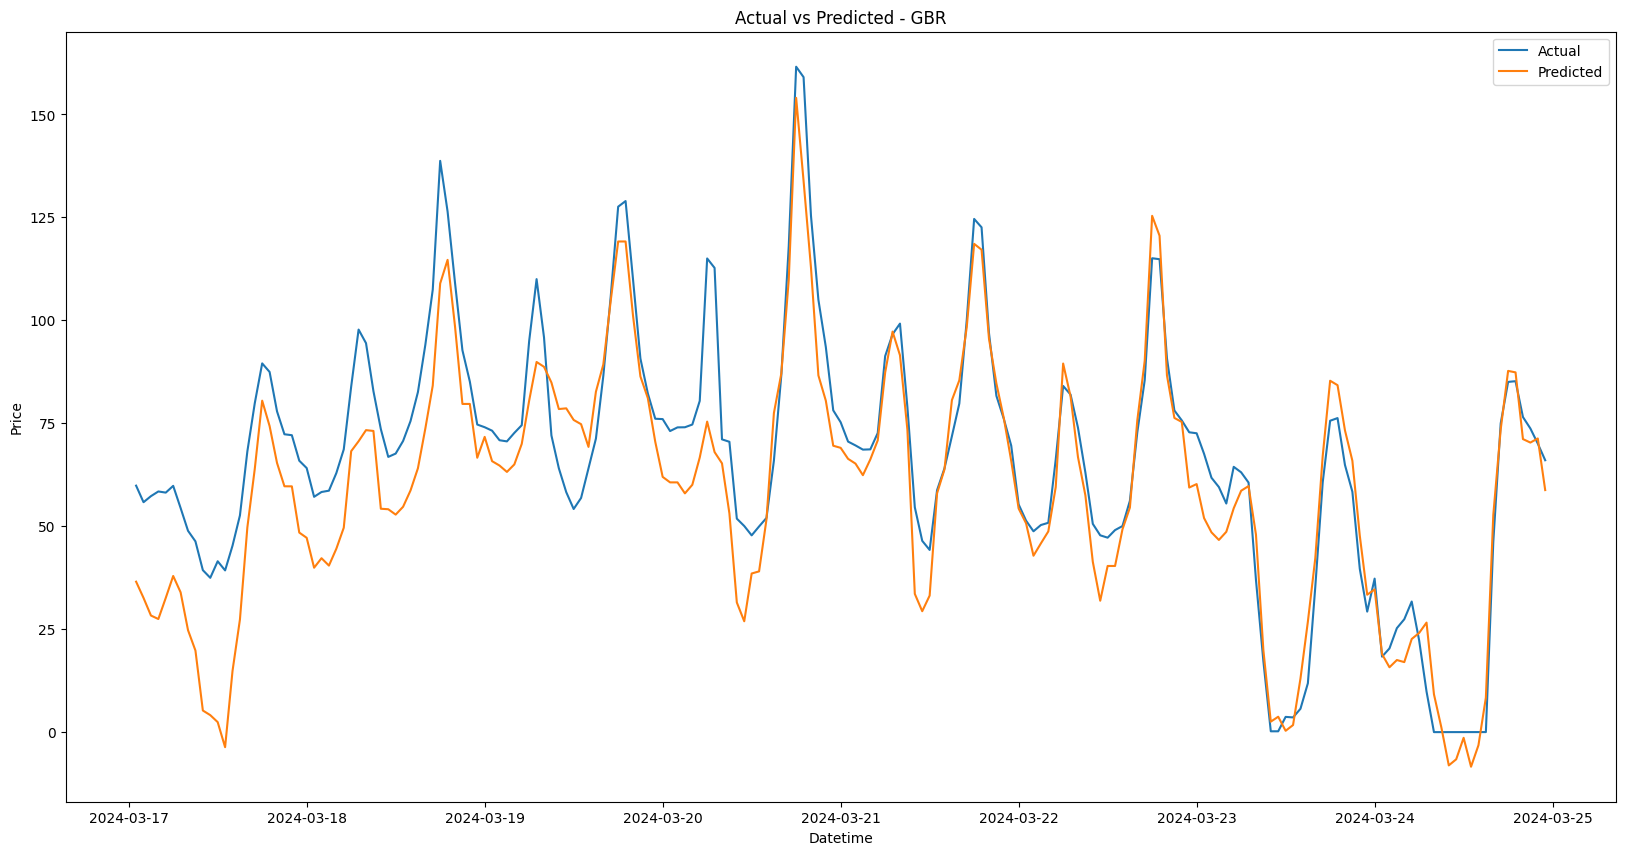

In [54]:
plt.figure(figsize=(20,10))
plt.plot(test['Datetime'], y_test, label='Actual')
plt.plot(test['Datetime'], gbr_pred, label='Predicted')
plt.title('Actual vs Predicted - GBR')
plt.xlabel('Datetime')
plt.ylabel('Price')
plt.legend()
plt.show()

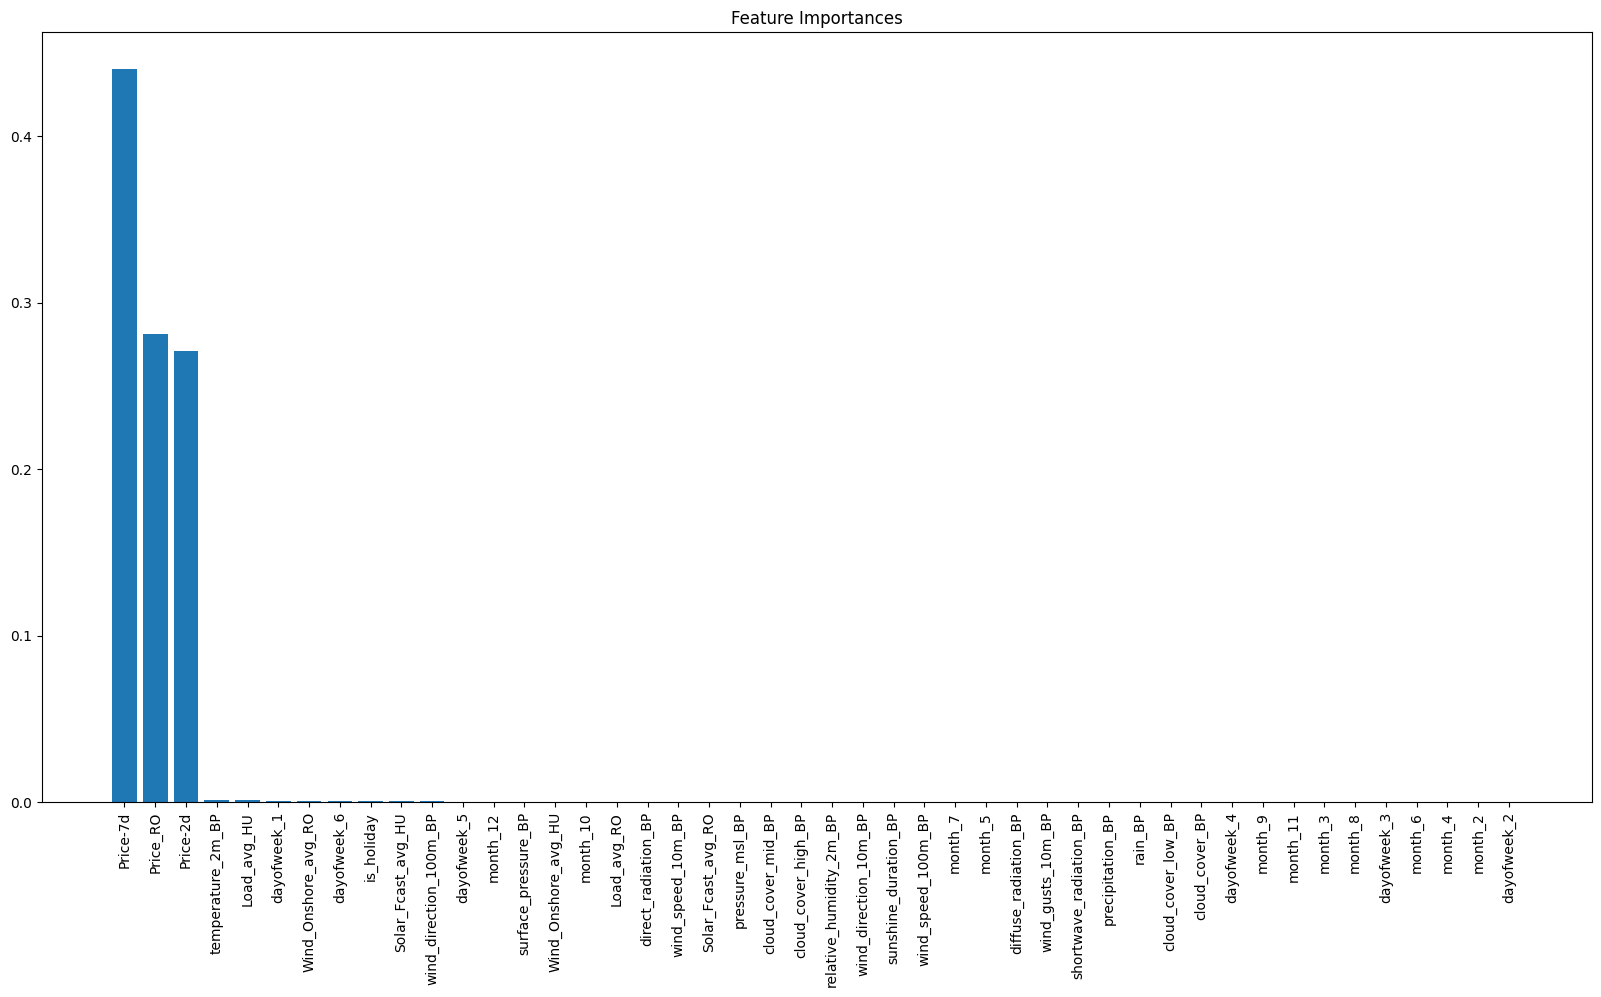

In [55]:
#plot the feature importances
plt.figure(figsize=(20,10))
plt.bar([x[0] for x in feature_importances], [x[1] for x in feature_importances])
plt.xticks(rotation=90)
plt.title('Feature Importances')
plt.show()

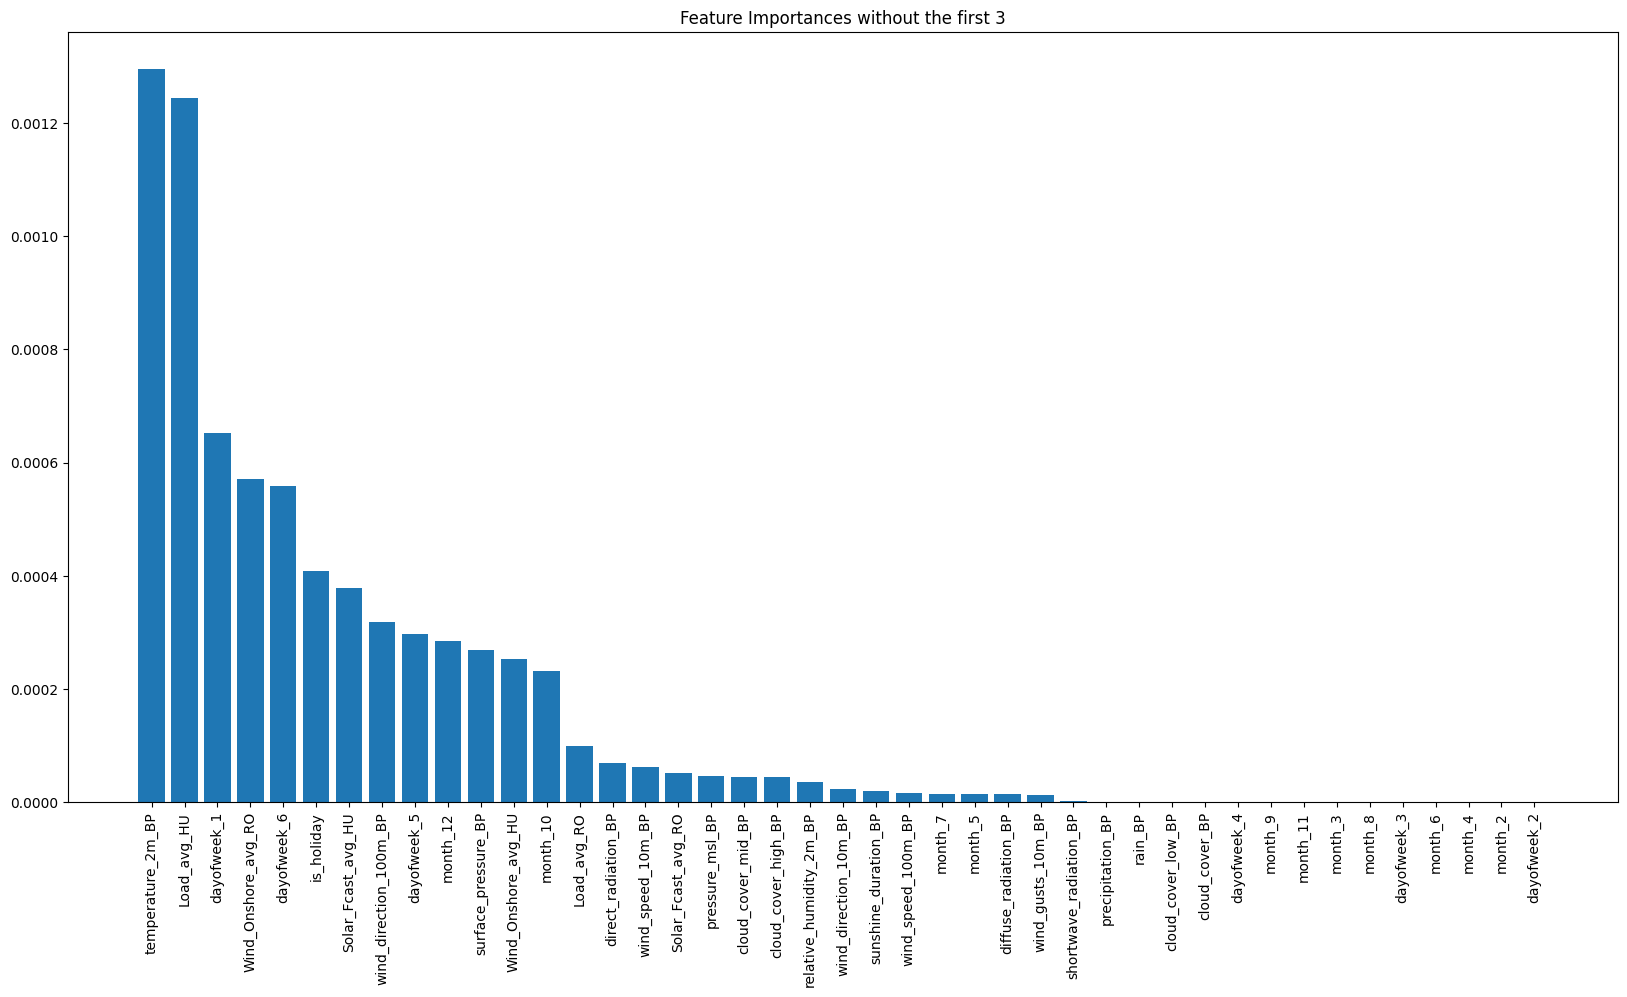

In [56]:
#plot the feature importances without the first 3
plt.figure(figsize=(20,10))
plt.bar([x[0] for x in feature_importances[3:]], [x[1] for x in feature_importances[3:]])
plt.xticks(rotation=90)
plt.title('Feature Importances without the first 3')
plt.show()

# Notes

Ma 8as adatokkal 9ig a holnapit (a mait mind ismerem)
- baseline1 az 1 heti adat
- baseline2 hasonló időjárású nap

Kiértékelés:
- v1 abs hiba (hány eurót tévedtünk)
- v2 adott órában mennyi a load (termelés / fogyasztás), hiba súlyozva a teljes fogyasztással

Opciók
- recurrent nn predictor (?)
- gbm regressor
-- (előzö napi adatok, napelemek termelése, román adatok, hőmérséklet..., körny ország árai)
-- walk forward opt

keretrendszer
feture inportance alapján feature selection 
- változásuk követése !!!

(talán osztrák is számít, meg kell nézni melyik számít)

időjárási adatok (első körben tényadatok, nem előrejelzés) próbálkozni kell, drága lehet, kb kizárt 

- végén fontos és ***nem fontos*** változók listája

3 fontos időjárás (régiós, a napi bontás is jó)
- hány fok van (fűtés / hűtés)
- besugárzás
- szélerősség


-Hányszor volt negatív ár - statisztika róla (Meg tudjuk-e mondani, hogy mikor lesz negatív ár)
-- Ez is lehet célváltozó és kiértékelés

- Napi egy órát kikapcsoljuk, cél: mikor legyen (mert a többi órában többet tudunk termelni)
-- Meg lehet nézni, hogy melyik lesz a legdrágább óra
